In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import re
from ast import literal_eval
import seaborn as sns
import decimal

In [2]:
import sys  
sys.path.insert(0, '../scripts')

from D_plot_specificity_matrix_utils import (peptide_per_clonotype_by_gem_size,
                                             multiple_peptides_per_gem_w_filtering,
                                             calc_binding_concordance,
                                             epitope_sorter_index,
                                             peptides_per_gem)

In [3]:
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})

In [4]:
def HLA_cd8_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace(",", "").replace("'","").split(" ")

def cdr3_lst_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace("'","").split(" ")

def epitope_converter(x):
    #define format of datetime
    return [y for y in x.replace("[","").replace("]","").replace("\n","").split("'") if (y != '') & (y != ' ')]

def peptide_hla_converter(x):
    return re.findall("\w+\s{1}\w{1}\d+", x.replace("[","").replace("]","").replace("\n","").replace("'",""))

def literal_converter(val):
    # replace NaN with '' and perform literal eval on the rest
    return [] if val == '' else literal_eval(val)

converters = {'peptide_HLA_lst': peptide_hla_converter,
              'umi_count_lst_mhc': literal_eval,
              'umi_count_lst_TRA': literal_converter,'umi_count_lst_TRB': literal_converter,
              'cdr3_lst_TRA': cdr3_lst_converter,
              'cdr3_lst_TRB': cdr3_lst_converter,
              'HLA_lst_mhc': cdr3_lst_converter,'HLA_cd8': HLA_cd8_converter} #

In [5]:
def notnan(x):
    return x == x

In [6]:
def get_multiplets(df):
    #tmp = df[idx1 & idx2]
    dct = df.groupby(['ct','peptide_HLA']).gem.count() > 1
    idx = df.set_index(['ct','peptide_HLA']).index.map(dct)
    return idx.fillna(False)

In [50]:
def plot_specificity(title, df, max_gems, save=True):
    # Define order for peptides
    #rank = {'GILGFVFTL A0201':1,'GLCTLVAML A0201':2,'NLVPMVATV A0201':3,'CLGGLLTMV A0201':4,
    #        'FLYALALLL A0201':5,'VLEETSVML A0201':6,'YVLDHLIVV A0201':7,
    #        'RVRAYTYSK A0301':8,'RPHERNGFTV B0702':9,'RPHERNGFTVL B0702':10,
    #        'RPPIFIRRL B0702':11,'TPRVTGGGAM B0702':12,'TPSVSSSISSL B0702':13}
    #df['rank'] = df.peptide_HLA.map(rank)

    # Sort
    df.ct = df.ct.astype(int).astype(str)
    df.sort_values(by=['epitope_rank','gems_per_specificity','binding_concordance'], #,'ct'
                       ascending=[True, False, False], inplace=True) #, True

    # devide GEMs by max concordance and outliers
    dct = df.groupby('ct').binding_concordance.max()
    df['max_conc'] = df.ct.map(dct)
    idx = df.binding_concordance == df.max_conc

    def modify_legend(h,l):
        flag = False
        labels = []
        handles = []
        for e, le in enumerate(l):
            if flag:
                if (int(float(le)) % 10 == 0) | (le == '1'):
                    labels.append(le)
                    handles.append(h[e])
            if le == 'gems_per_specificity':
                flag = True
        labels.append(le) #added
        handles.append(h[e]) #added
        return handles, labels
    
    # Style
    # https://seaborn.pydata.org/generated/seaborn.axes_style.html
    sns.set_style('ticks', {'axes.edgecolor': '0', #'axes.facecolor':'lightgrey',
                            'xtick.color': '0',
                            'ytick.color': '0'})
    sns.set_context("paper",font_scale=2)

    fig = plt.figure(figsize=(20,8)) #figsize=(20,6)
    sns.scatterplot(data=df[idx], x='ct', y='peptide_HLA',
                    size='gems_per_specificity', sizes=(10,1000), size_norm=(1,max_gems),
                    hue='binding_concordance', palette='viridis_r', hue_norm=(0,1),
                    legend='full', linewidth=0)
    sns.scatterplot(data=df[~idx], x='ct', y='peptide_HLA',
                    size='gems_per_specificity', sizes=(10,1000), size_norm=(1,max_gems),
                    hue='binding_concordance', palette='viridis_r', hue_norm=(0,1),
                    legend=False, linewidth=0)
    ax = plt.gca()
    sm = plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=1), cmap='viridis_r') # hack for cbar
    sm.set_array([]) # hack for cbar
    #fig.colorbar(sm, ax=ax, pad=0.01)
    cb = fig.colorbar(sm, ax=ax, orientation='horizontal', label='Binding Concordance', fraction=0.06, pad=0.3) #https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.colorbar.html
    #cb.set_label(label='Binding Concordance', labelpad=-10) #labelpad=-10
    
    h,l = ax.get_legend_handles_labels()
    h,l = modify_legend(h,l)
    ax.legend(h, l, bbox_to_anchor=(0.5, -0.8), loc=9, frameon=False, title='GEMs', ncol=len(l)) #bbox_to_anchor=(0.5, -0.5)

    #plt.title('%d clonotypes (%d GEMs)' %(df.ct.nunique(), df.gem.nunique()))
    plt.xlabel('%d clonotypes (across %d GEMs)' %(df.ct.nunique(), df.gem.nunique()), labelpad=20)
    #plt.xlabel('')
    plt.ylabel('')

    sns.despine(bottom=False, trim=True, offset={'left':-30})
    max_tick = int(np.floor(len(df.ct.unique())/100)*100)
    all_ticks = np.arange(100, max_tick+100, 100)
    ax.set_xticks(all_ticks) #ax.set_xticks([])
    ax.set_xticklabels(all_ticks, rotation=30, ha='right') #ax.set_xticklabels([])
    
    if save:
        plt.savefig(title, bbox_inches='tight', dpi=300)
    plt.show()

# Input

In [8]:
#DIR = '../experiments/exp13/run1_archive/'
#DIR = '../experiments/exp10x/run1/'
DIR = '../experiments/exp13/run3/'

In [9]:
OPT_THR = DIR + 'cat/eval_clonotypes/threshold/opt.csv'

In [10]:
#VALID = DIR + 'cat/eval_clonotypes/valid_ct.csv'
VALID = DIR + 'cat/eval_clonotypes/valid_ct.csv'
#OS2 = '../experiments/exp13/run2/cat/eval_clonotypes/valid_ct.csv'

In [11]:
HTO = DIR + 'brc/outfile.csv'
#GEX = '../experiments/exp13/run1_archive/tcr/usable_gems.txt'
GEX = DIR + 'cat/eval_clonotypes/threshold/gex.txt'
#TCR = '../experiments/exp13/run1/tcr/cellranger_tot/outs/multi/vdj_t/all_contig_annotations.csv'
TCR = DIR + 'tcr/cellranger_tot/outs/multi/vdj_t/all_contig_annotations.csv'
TCR_ARC = '../experiments/exp13/run1_archive/tcr/cellranger_tot/outs/multi/vdj_t/all_contig_annotations.csv'

In [12]:
filter_set = 'comb' #'indv'
AUC = DIR + 'cat/similarity_assessment/plt_df/%s.auc.csv' %filter_set

In [13]:
#filter_set = 'comb'
#AUC = 'tmp_files/similarity.auc.%s.csv' %filter_set

# Load

In [14]:
auc_df = pd.read_csv(AUC)

In [15]:
tcr = pd.read_csv(TCR)
tcr_dct = tcr.groupby('barcode').is_cell.unique().apply(lambda x: x[0])

In [16]:
tcr_arc = pd.read_csv(TCR_ARC)
arc_dct = tcr_arc.groupby('barcode').is_cell.unique().apply(lambda x: x[0])

In [17]:
tcr_cell = pd.merge(arc_dct,tcr_dct, left_index=True,right_index=True, how='outer', suffixes=['_arc','_gex'])

In [18]:
tcr_cell

,is_cell_arc,is_cell_gex
barcode,,
AAACCTGAGAAGGTGA-1,True,False
AAACCTGAGACATAAC-1,True,True
AAACCTGAGACTTGAA-1,True,False
AAACCTGAGATGTCGG-1,True,True
AAACCTGAGCCCAGCT-1,True,True
...,...,...
TTTGTCATCCCAACGG-1,True,True
TTTGTCATCGACCAGC-1,True,False
TTTGTCATCGGCGCAT-1,False,False


In [19]:
#gex = pd.read_csv(GEX, header=None, names=['gem'])
gex = np.loadtxt(GEX, dtype='str')

In [20]:
opt_thr = pd.read_csv(OPT_THR, index_col=0, header=None, names=['thr']).thr.dropna()
opt_thr.delta_umi_mhc = 1
opt_thr.delta_umi_TRA = 0
opt_thr.delta_umi_TRB = 0
opt_thr

umi_count_mhc    2.0
delta_umi_mhc    1.0
umi_count_TRA    0.0
delta_umi_TRA    0.0
umi_count_TRB    0.0
delta_umi_TRB    0.0
Name: thr, dtype: float64

In [21]:
os1 = pd.read_csv(VALID, converters=converters)

In [22]:
os1.fillna({'umi_count_mhc':0, 'delta_umi_mhc':0, 'umi_count_mhc_rel':0,
           'umi_count_cd8':0, 'delta_umi_cd8':0,
           'umi_count_TRA':0, 'delta_umi_TRA':0,
           'umi_count_TRB':0, 'delta_umi_TRB':0,
           'cdr3_TRA':'','cdr3_TRB':''}, inplace=True)

In [42]:
hto = pd.read_csv(HTO, skiprows=1, header=None,
                  names=['gem','seurat','umi_count_hto','feature_rna','count_hto','feature_hto','hto_max_id','hto_sec_id','hto_margin','hto_classification','hto_global_class','hash_id'])

In [22]:
#df = pd.merge(os1, hto, how='left', on='gem')

In [23]:
#hto_singlets = df[df.hto_global_class == 'Negative']

In [24]:
#hto_singlets[['sample_id','hash_id','sample_id_lst','peptide_HLA_lst','umi_count_lst_mhc','tcr_category','hto_classification']]#.sample_id.value_counts()

In [23]:
df = pd.merge(os1, tcr_cell, left_on='gem',right_index=True) #exp13_3

In [24]:
df['gex'] = df.gem.isin(gex) # exp13_3
#df['gex'] = df.gem.isin([]) # 10x

# Reduction in GEMs and CTs when filtering

In [25]:
df.single_barcode_mhc = np.where(df.single_barcode_mhc, 'pMHC singlet','pMHC multiplet')

In [26]:
df['clonotype_multiplet'] = df.ct.map(df.groupby('ct').size() > 1)

In [27]:
total_gems = len(df.gem.unique())
total_cts = len(df.ct.unique())
#total_acc = round(df.train_label.sum() / len(df.train_label.dropna()) * 100, 1)
total_acc = round(df.pep_match.sum() / len(df.pep_match.dropna()) * 100, 1)
total_conc = round(calc_binding_concordance(df[df.clonotype_multiplet].copy(), 'ct').binding_concordance.mean() * 100, 1)

In [28]:
idx1 = eval(' & '.join([f'(df.{k} >= {abs(v)})' for k,v in opt_thr.items()]))

idx2 = df.hto_global_class == 'Singlet'

idx3 = df.apply(lambda row: row.peptide_HLA.split()[-1] in row.HLA_cd8 if (notnan(row.peptide_HLA) & notnan(row.HLA_cd8)) else False, axis=1)

idx4 = df['exclude_single-chain_TCRs']

idx5 = get_multiplets(df)

In [53]:
idx6 = df.cell_flag

AttributeError: 'DataFrame' object has no attribute 'cell_flag'

In [29]:
idx6 = df.is_cell_arc
idx7 = df.is_cell_gex

In [30]:
idx8 = df.gex

In [31]:
filterings = [idx1,
              (idx1 & idx3),
              (idx1 & idx2 & idx3),
              (idx1 & idx2 & idx3 & idx4),
              (idx1 & idx2 & idx3 & idx4 & idx6),
              (idx1 & idx2 & idx3 & idx4 & idx6 & idx5)]
labels = ['optimal threshold',
          'matching HLA',
          'hashing singlets',
          'complete TCRs',
          'is cell',
          'specificity multiplets']
palette = ['grey','#ffffcc','#c7e9b4','#7fcdbb','#41b6c4','#2c7fb8','#253494']

In [58]:
# Exp13_3: Showing individual effects of filtering
filterings = [idx1,
              idx3,
              idx2,
              idx4,
              idx5,
              idx6,
              idx7,
              idx8]
labels = ['optimal threshold',
          'matching HLA',
          'hashing singlets',
          'complete TCRs',
          'specificity multiplets',
          'is cell',
          'is cell (GEX)',
          'is viable cell']
palette = ['grey','yellow','#ffffcc','#c7e9b4','#7fcdbb','#41b6c4','#2c7fb8','#253494','black']

In [32]:
# Showing combined effects in the same order
filterings = [idx1,
              (idx1 & idx3),
              (idx1 & idx2 & idx3),
              (idx1 & idx2 & idx3 & idx4),
              (idx1 & idx2 & idx3 & idx4 & idx5),
              (idx1 & idx2 & idx3 & idx4 & idx5 & idx6),
              (idx1 & idx2 & idx3 & idx4 & idx5 & idx7),
              (idx1 & idx2 & idx3 & idx4 & idx5 & idx8)]
labels = ['optimal threshold',
          'matching HLA',
          'hashing singlets',
          'complete TCRs',
          'specificity multiplets',
          'is cell',
          'is cell (GEX)',
          'is viable cell']
palette = ['grey','yellow','#ffffcc','#c7e9b4','#7fcdbb','#41b6c4','#2c7fb8','#253494','black']

In [53]:
# Optimal order for combining thresholds? Only choose opt thr + match HLA
filterings = [idx1,
              (idx1 & idx3),
              (idx1 & idx3 & idx4),
              (idx1 & idx3 & idx6),
              (idx1 & idx3 & idx7),
              (idx1 & idx3 & idx8),
              (idx1 & idx3 & idx6 & idx4),
              (idx1 & idx3 & idx6 & idx4 & idx2),
              (idx1 & idx2 & idx3 & idx4 & idx2 & idx5)]
labels = ['optimal threshold',
          'matching HLA',
          '+ complete TCRs',
          'is cell',
          'is cell (GEX)',
          'is functional cell',
          'complete TCRs',
          'hashing singlets',
          'specificity multiplets']
palette = ['grey','yellow','brown','#ffffcc','#c7e9b4','#7fcdbb','#41b6c4','#2c7fb8','#253494','black']

# Main

In [33]:
plt_df = pd.DataFrame(columns=['counts','percent','variable','filters'])
plt_df.loc[0,['counts','percent','variable','filters']] = total_gems, 100, 'GEMs', 'total'
plt_df.loc[1,['counts','percent','variable','filters']] = total_cts, 100, 'clonotypes', 'total'
plt_df.loc[2,['counts','percent','variable','filters']] = total_acc, total_acc, 'accuracy', 'total'
plt_df.loc[3,['counts','percent','variable','filters']] = total_conc, total_conc, 'avg. conc.', 'total'

In [34]:
plt_df

,counts,percent,variable,filters
0,6073,100,GEMs,total
1,2441,100,clonotypes,total
2,87.8,87.8,accuracy,total
3,76.9,76.9,avg. conc.,total


### Initializing dataframe for TCR category summary

In [35]:
data = ['total'] + labels #+ labels_icon # OBS!
binding_category = ['normal','outlier']
tcr_category = ['missing chain','multiple chains','unique chains']

indexes = len(binding_category)*len(tcr_category)*len(data)

# Initiate dataframe
smry = pd.DataFrame(columns=['freq','frac','pos'],index=np.arange(indexes))
smry.index = pd.MultiIndex.from_product([data, binding_category, tcr_category],
                                        names=['data', 'binding_category','tcr_category'])

#### Populating dataframe with summary of total data

In [36]:
tmp = calc_binding_concordance(df.copy(), 'ct')
tmp['binding_category'] = np.where(tmp.binding_concordance > 0.5, 'normal','outlier')

stmp = tmp.groupby(['binding_category','tcr_category']).size().to_frame().rename(columns={0:'freq'})
stmp.loc['normal','frac'] = stmp.loc['normal','freq'].values / stmp.loc['normal','freq'].sum() * 100
stmp.loc['outlier','frac'] = stmp.loc['outlier','freq'].values / stmp.loc['outlier','freq'].sum() * 100
stmp['pos'] = 0

stmp = pd.concat({'total': stmp}, names=['data']) #stmp['data'] = 'total'

smry.loc[stmp.index, ['freq','frac','pos']] = stmp

### Initializing dataframe for pMHC summary

In [37]:
data = ['total'] + labels #+ labels_icon # OBS!
binding_category = ['normal','outlier']
pmhc_category = ['pMHC multiplet','pMHC singlet']

indexes = len(binding_category)*len(pmhc_category)*len(data)

# Initiate dataframe
pmhc = pd.DataFrame(columns=['freq','frac','pos'], index=np.arange(indexes))
pmhc.index = pd.MultiIndex.from_product([data, binding_category, pmhc_category],
                                        names=['data', 'binding_category','single_barcode_mhc'])


#### Populating dataframe with summary of total data

In [38]:
#pfs = list()
ptmp = tmp.groupby(['binding_category','single_barcode_mhc']).size().to_frame().rename(columns={0:'freq'})

ptmp.loc['normal','frac'] = ptmp.loc['normal','freq'].values / ptmp.loc['normal','freq'].sum() * 100
ptmp.loc['outlier','frac'] = ptmp.loc['outlier','freq'].values / ptmp.loc['outlier','freq'].sum() * 100
ptmp = pd.concat({'total': ptmp}, names=['data']) #ptmp['data'] = 'total'
#pfs.append(pmhc)

pmhc.loc[ptmp.index, ['freq','frac']] = ptmp

In [39]:
df.rename(columns={'rank':'epitope_rank'}, inplace=True)

In [40]:
i = len(plt_df)

#for idx, label in zip([idx1, idx2, (idx1 & idx2)],
#                      ['optimal threshold','hashing singlets', 'opt. thr. & hashing']):

print(filter_set)
for idx, label in zip(filterings, labels): #OBS! add _icon
    sub = df[idx].copy() #icon[idx].copy() #  #OBS! 
    
    tmp = calc_binding_concordance(sub, 'ct')
    tmp['binding_category'] = np.where(tmp.binding_concordance > 0.5, 'normal','outlier')
    
    n_g = len(sub.gem.unique())
    n_c = len(sub.ct.unique())
    #n_a = round(df[idx].train_label.sum() / len(df[idx].train_label.dropna()) * 100, 1)
    n_a = round(sub.pep_match.sum() / len(sub.pep_match.dropna()) * 100, 1)
    n_s = round(tmp[tmp.clonotype_multiplet].binding_concordance.mean() * 100, 1)
    plt_df.loc[i , ['counts','percent','variable','filters']] = n_g, n_g / total_gems * 100, 'GEMs', label
    plt_df.loc[i+1,['counts','percent','variable','filters']] = n_c, n_c / total_cts * 100, 'clonotypes', label
    plt_df.loc[i+2,['counts','percent','variable','filters']] = n_a, n_a, 'accuracy', label
    plt_df.loc[i+3,['counts','percent','variable','filters']] = n_s, n_s, 'avg. conc.', label
    
    stmp = tmp.groupby(['binding_category','tcr_category']).size().to_frame().rename(columns={0:'freq'})
    #smry = smry.reset_index().groupby('tcr_category').freq.sum().to_frame()
    stmp.loc['normal','frac'] = stmp.loc['normal','freq'].values / stmp.loc['normal','freq'].sum() * 100
    stmp.loc['outlier','frac'] = stmp.loc['outlier','freq'].values / stmp.loc['outlier','freq'].sum() * 100
    stmp['pos'] = i / 4
    #dfs.append(stmp)
    stmp = pd.concat({label: stmp}, names=['data']) #stmp['data'] = label
    # Fill
    smry.loc[stmp.index, ['freq','frac','pos']] = stmp
    
    ptmp = tmp.groupby(['binding_category','single_barcode_mhc']).size().to_frame().rename(columns={0:'freq'})
    ptmp.loc['normal','frac'] = ptmp.loc['normal','freq'].values / ptmp.loc['normal','freq'].sum() * 100
    ptmp.loc['outlier','frac'] = ptmp.loc['outlier','freq'].values / ptmp.loc['outlier','freq'].sum() * 100
    ptmp = pd.concat({label: ptmp}, names=['data']) #ptmp['data'] = label
    #pfs.append(ptmp)
    pmhc.loc[ptmp.index, ['freq','frac']] = ptmp
    
    i += 4
    
    filename = DIR + "plt/eval_filters/" + f"specificity.{filter_set}.{'_'.join(label.split())}.png"
    print(filename)
    #plot_specificity(filename, tmp[~tmp.peptide_HLA.isin(ignore_peptides)], df.gems_per_specificity.max(), save=True)
    #peptide_per_clonotype_by_gem_size(tmp, y='peptide_HLA', color_by_hashing=False, save_tuba=filename, show=False)

comb
../experiments/exp13/run3/plt/eval_filters/specificity.comb.optimal_threshold.png
../experiments/exp13/run3/plt/eval_filters/specificity.comb.matching_HLA.png
../experiments/exp13/run3/plt/eval_filters/specificity.comb.hashing_singlets.png
../experiments/exp13/run3/plt/eval_filters/specificity.comb.complete_TCRs.png
../experiments/exp13/run3/plt/eval_filters/specificity.comb.specificity_multiplets.png
../experiments/exp13/run3/plt/eval_filters/specificity.comb.is_cell.png
../experiments/exp13/run3/plt/eval_filters/specificity.comb.is_cell_(GEX).png
../experiments/exp13/run3/plt/eval_filters/specificity.comb.is_viable_cell.png


../experiments/exp13/run3/plt/eval_filters/specificity.comb.raw.pub.png


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/matplotlib/colorbar.py:214: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


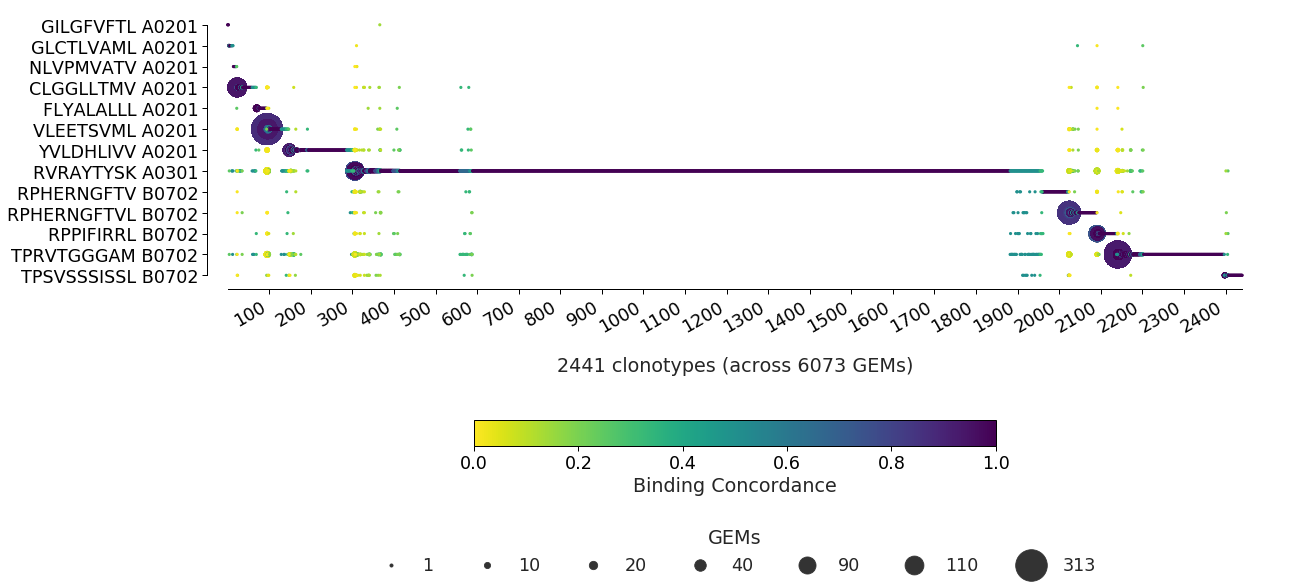

In [52]:
filename = DIR + "plt/eval_filters/" + f"specificity.comb.raw.pub.png" #{filter_set}
print(filename)
tmp = calc_binding_concordance(df.copy(), 'ct')
gmx = tmp.gems_per_specificity.max()
plot_specificity(filename, tmp, gmx, save=True)

../experiments/exp13/run3/plt/eval_filters/specificity.comb.opt_hla.pub.png


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/matplotlib/colorbar.py:214: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


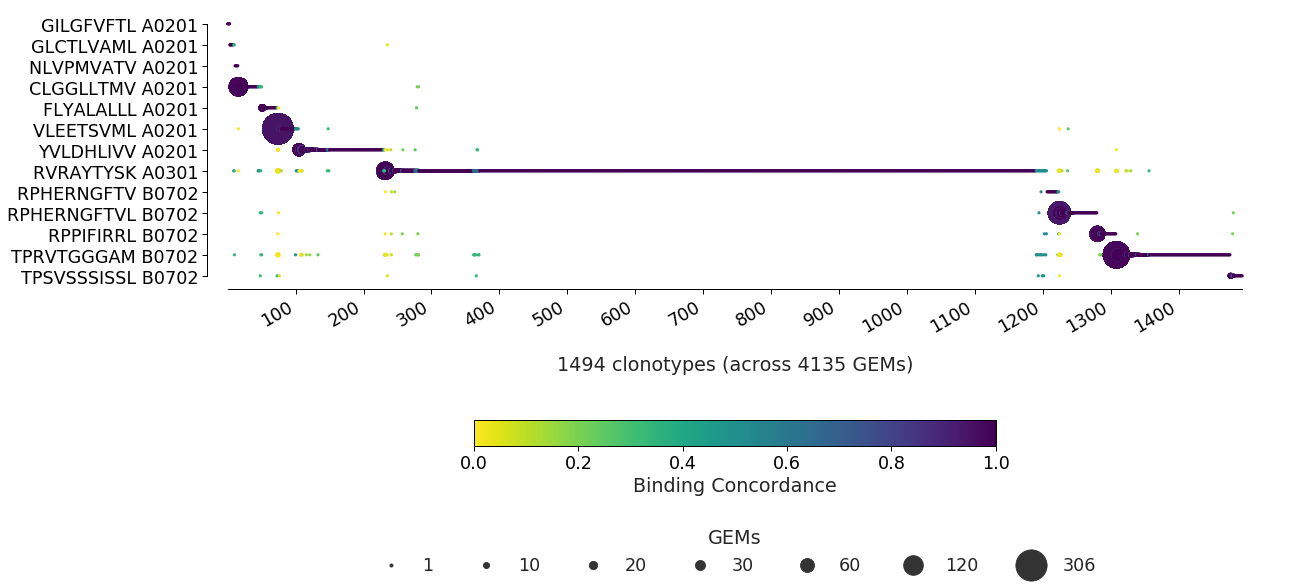

In [53]:
filename = DIR + "plt/eval_filters/" + f"specificity.comb.opt_hla.pub.png" #{filter_set}
print(filename)
tmp = calc_binding_concordance(df[idx1 & idx3].copy(), 'ct')

plot_specificity(filename, tmp, gmx, save=True)

../experiments/exp13/run3/plt/eval_filters/specificity.comb.opt_hla_tcr.pub.png


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/matplotlib/colorbar.py:214: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


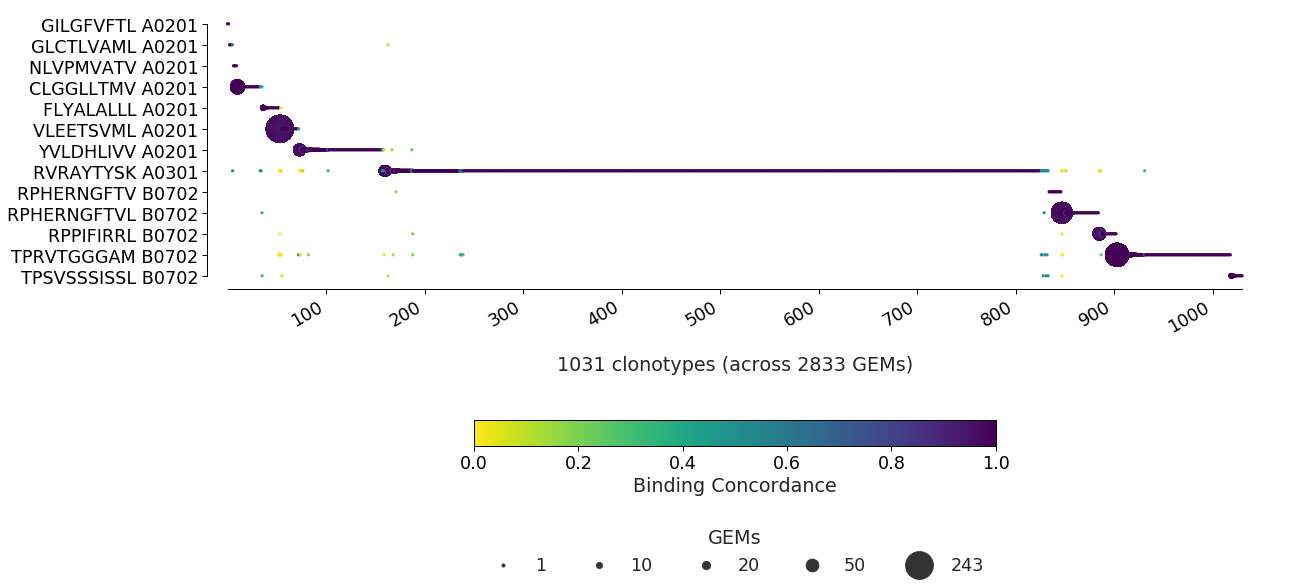

In [54]:
filename = DIR + "plt/eval_filters/" + f"specificity.comb.opt_hla_tcr.pub.png" #{filter_set}
print(filename)
tmp = calc_binding_concordance(df[idx1 & idx3 & idx4].copy(), 'ct')

plot_specificity(filename, tmp, gmx, save=True)

In [79]:
plt_df

,counts,percent,variable,filters
0,6073,100,GEMs,total
1,2441,100,clonotypes,total
2,87.8,87.8,accuracy,total
3,76.9,76.9,avg. conc.,total
4,4986,82.101103,GEMs,optimal threshold
5,2060,84.391643,clonotypes,optimal threshold
6,95.3,95.3,accuracy,optimal threshold
7,90.6,90.6,avg. conc.,optimal threshold
8,5004,82.397497,GEMs,matching HLA
9,1822,74.64154,clonotypes,matching HLA


In [70]:
int(float('1.0'))

1

In [57]:
tmp.loc[tmp.VDJdb_check == False, ['ct','peptide_HLA','peptide_HLA_lst','VDJdb_pep','VDJdb_check']].dropna()

,ct,peptide_HLA,peptide_HLA_lst,VDJdb_pep,VDJdb_check
38942,8,FLYALALLL A0201,[FLYALALLL A0201],['GILGFVFTL'],False
63201,8,RPPIFIRRL B0702,"[CLLGTYTQDV A0201, AVFDRKSDAK A1101, RPPIFIRRL...",['GILGFVFTL'],False
128333,8,RPPIFIRRL B0702,"[SLLMWITQV A0201, KLGGALQAK A0301, RPPIFIRRL B...",['GILGFVFTL'],False
75917,51038,RPPIFIRRL B0702,"[SLFNTVATLY A0201, RPPIFIRRL B0702]",['SLFNTVATL'],False
213,8,KLGGALQAK A0301,"[RIAAWMATY A0301, AAKGRGAAL B0801, IVTDFSVIK A...",['GILGFVFTL'],False
...,...,...,...,...,...
102023,8,FLASKIGRLV A0201,"[LLMGTLGIVC A0201, KLGGALQAK A0301, IVTDFSVIK ...",['GILGFVFTL'],False
156923,8,AYSSAGASI A2402,"[KTWGQYWQV A0201, NLVPMVATV A0201, QPRAPIRPI B...",['GILGFVFTL'],False
102537,30353,IVTDFSVIK A1101,"[ILKEPVHGV A0201, CYTWNQMNL A2402, LLFGYPVYV A...",['GILGFVFTL'],False
121587,30353,RAKFKQLL B0801,"[YLNDHLEPWI A0201, KLGGALQAK A0301, RIAAWMATY ...",['GILGFVFTL'],False


In [43]:
tmp.loc[(tmp.binding_category == 'outlier'),
        ['binding_concordance','clonotype','ct','peptide_HLA','umi_count_lst_mhc','peptide_HLA_lst','HLA_cd8']].peptide_HLA.value_counts()

RVRAYTYSK A0301      100
TPRVTGGGAM B0702      67
TPSVSSSISSL B0702     21
VLEETSVML A0201       19
CLGGLLTMV A0201       18
YVLDHLIVV A0201       17
RPHERNGFTV B0702      14
RPPIFIRRL B0702       12
RPHERNGFTVL B0702      6
GLCTLVAML A0201        5
FLYALALLL A0201        4
NLVPMVATV A0201        1
GILGFVFTL A0201        1
Name: peptide_HLA, dtype: int64

In [121]:
15/56

0.26785714285714285

In [87]:
tmp.loc[tmp.binding_category == 'outlier',
        ['binding_concordance','clonotype','ct','peptide_HLA','umi_count_lst_mhc','peptide_HLA_lst','HLA_cd8']].shape

(56, 7)

In [101]:
tmp.columns

Index(['gem', 'clonotype', 'num_clonotype', 'ct', 'genes_TRA', 'genes_TRB',
       'genes_lst_TRA', 'genes_lst_TRB', 'length_TRA', 'cdr1_TRA',
       ...
       'gex', 'is_cell_arc', 'is_cell_gex', 'clonotype_multiplet',
       'epitope_rank', 'max_conc', 'gems_per_spec_hla_match',
       'hla_concordance', 'binding_category', 'rank'],
      dtype='object', length=114)

In [112]:
sec_pep_eq_conc_pep = tmp[tmp.binding_category == 'outlier'].apply(lambda row: tmp[(tmp.ct == row.ct) & (tmp.max_conc == tmp.binding_concordance)].peptide_HLA.to_list()[0] in row.peptide_HLA_lst if len(row.peptide_HLA_lst) > 1 else np.nan, axis=1)
sec_pep_eq_conc_pep.sum()

47

In [95]:
hla_match_btw_pep = tmp[tmp.binding_category == 'outlier'].apply(lambda row: row.peptide_HLA_lst[-2].split()[-1] == row.peptide_HLA_lst[-1].split()[-1] if len(row.peptide_HLA_lst) > 1 else np.nan, axis=1)
hla_match_btw_pep.sum()

7

In [96]:
hla_match_to_smpl = tmp[tmp.binding_category == 'outlier'].apply(lambda row: row.peptide_HLA_lst[-2].split()[-1] in row.HLA_cd8 if len(row.peptide_HLA_lst) > 1 else np.nan, axis=1)
hla_match_to_smpl.sum()

34

In [98]:
hla_match_to_smpl.isna().sum()

6

In [113]:
47/50

0.94

In [170]:
df.peptide_HLA.unique()

array(['RPHERNGFTVL B0702', 'RVRAYTYSK A0301', 'CLGGLLTMV A0201',
       'TPRVTGGGAM B0702', 'YVLDHLIVV A0201', 'TPSVSSSISSL B0702',
       'VLEETSVML A0201', 'RPHERNGFTV B0702', 'RPPIFIRRL B0702',
       'FLYALALLL A0201', 'NLVPMVATV A0201', 'GILGFVFTL A0201',
       'GLCTLVAML A0201'], dtype=object)

In [171]:
ignore_peptides = ['NLVPMVATV A0201', 'GILGFVFTL A0201', 'GLCTLVAML A0201']

../experiments/exp13/run3/plt/eval_filters/specificity.indv.raw.png


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/matplotlib/colorbar.py:214: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


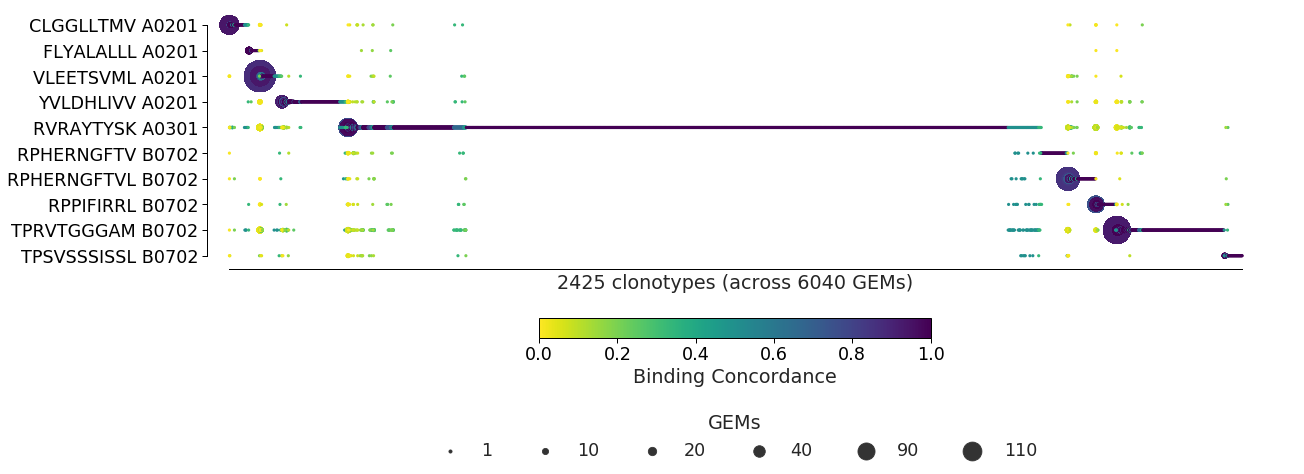

{2052, 4100, 4107, 2062, 2066, 4120, 4121, 26, 34, 2082, 37, 4149, 2105, 2106, 2112, 4161, 2117, 4167, 4171, 4176, 4182, 4192, 4212, 120, 4220, 4227, 4232, 140, 4242, 4245, 4249, 4256, 4258, 165, 4263, 4264, 4271, 4277, 4280, 4281, 187, 2238, 4286, 2241, 4296, 4297, 4305, 4311, 4315, 4316, 242, 4342, 2300, 4348, 4350, 4354, 260, 4359, 2324, 4373, 4376, 4379, 4380, 283, 4388, 4389, 2343, 4392, 4393, 2353, 4404, 4409, 316, 4413, 4414, 319, 4415, 4422, 4423, 2380, 341, 4438, 4439, 4441, 345, 4442, 4444, 352, 4449, 2402, 356, 4453, 2406, 4454, 365, 2421, 4470, 4469, 377, 4476, 4489, 4490, 4496, 2450, 2458, 2468, 4531, 2484, 439, 441, 4538, 443, 4541, 2497, 450, 4546, 4549, 457, 2515, 468, 4565, 2520, 4571, 485, 4584, 492, 4594, 4602, 2571, 526, 2577, 4636, 552, 2604, 557, 4657, 4658, 4659, 4662, 569, 4674, 584, 4683, 4684, 590, 2640, 4689, 2645, 4696, 4697, 604, 2661, 4710, 4716, 621, 4720, 4722, 2677, 4726, 637, 2686, 2687, 4735, 4742, 4747, 4762, 4772, 686, 4783, 4789, 2747, 4795, 701, 7

In [173]:
filename = DIR + "plt/eval_filters/" + f"specificity.{filter_set}.raw.png"
print(filename)
tmp = calc_binding_concordance(df[~df.peptide_HLA.isin(ignore_peptides)].copy(), 'ct')
plot_specificity(filename, tmp, tmp.gems_per_specificity.max(), save=True)
peptide_per_clonotype_by_gem_size(df, y='peptide_HLA', color_by_hashing=False, save_tuba=filename, show=False)

In [201]:
auc_df.rename(columns={'filtering':'filters'}, inplace=True)
auc_df['percent'] = auc_df.value * 100
dct = auc_df.groupby(['filters','variable']).percent.mean()
auc_df['counts'] = auc_df.set_index(['filters','variable']).index.map(dct)

In [202]:
auc_df.filters = np.where(auc_df.filters == 'is functional cell', 'is viable cell', auc_df.filters)

In [203]:
test_df = pd.concat([plt_df, auc_df])

In [204]:
test_df = test_df[test_df.variable.isin(['GEMs','accuracy','avg. conc.','AUC','AUC 0.1'])]

In [205]:
test_df['tmp'] = np.where(test_df.variable == 'AUC', test_df['counts'], test_df['percent'])

In [96]:
tmp = test_df.drop_duplicates(subset=['variable','filters']).groupby(['filters'], sort=False).tmp.mean().to_frame().reset_index()
tmp['variable'] = 'summary'
tmp['counts'] = tmp.tmp
tmp['percent'] = tmp.tmp
tmp

,filters,tmp,variable,counts,percent
0,total,68.802460,summary,68.802460,68.802460
1,optimal threshold,66.772127,summary,66.772127,66.772127
2,matching HLA,66.432775,summary,66.432775,66.432775
3,hashing singlets,66.640954,summary,66.640954,66.640954
4,complete TCRs,65.122794,summary,65.122794,65.122794
5,specificity multiplets,68.657528,summary,68.657528,68.657528
6,is cell,68.981211,summary,68.981211,68.981211
7,is cell (GEX),68.437785,summary,68.437785,68.437785
8,is viable cell,69.609388,summary,69.609388,69.609388


In [86]:
test_df = pd.concat([test_df, tmp])

In [206]:
test_df = test_df[test_df.variable.isin(['GEMs','accuracy','avg. conc.','AUC'])].copy() #,'summary'

In [168]:
test_df = plt_df.copy() # 10x without AUC :(

In [169]:
test_df.variable = np.where(test_df.variable == 'clonotypes','clones',test_df.variable)
test_df.variable = np.where(test_df.variable == 'avg. conc.','avg.\nconc.',test_df.variable)

In [170]:
cnt = test_df.groupby('filters', sort=False).counts.unique()
cnt_flat = [x for y in cnt.to_list() for x in y]

In [171]:
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})
sns.set_context("paper",font_scale=2)

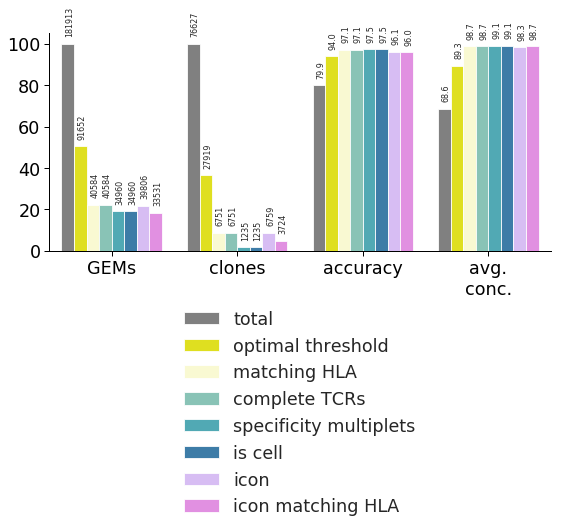

In [172]:
plt.figure(figsize=(9,4))#7
ax = sns.barplot(data=test_df, hue='filters',y='percent',x='variable', ci='sd',
                 palette=palette+palette_icon) #['grey','#ffffcc','#c7e9b4','#7fcdbb','#41b6c4','#2c7fb8','#253494']
for p, c in zip(ax.patches, cnt_flat):
    yoff = 7
    if type(c) == int:
        ax.annotate("%d" % c, xy=(p.get_x()+p.get_width()/2, p.get_height()), #p.get_width()
            xytext=(2, yoff), textcoords='offset points', ha="center", va="bottom", size=8, rotation=90)
    else:
        if decimal.Decimal(str(c)).as_tuple().exponent < -2:
            yoff = 12
        ax.annotate("%.1f" % round(c,1), xy=(p.get_x()+p.get_width()/2, p.get_height()), #p.get_width()
                xytext=(2, yoff), textcoords='offset points', ha="center", va="bottom", size=8, rotation=90) #
    
ax.legend(title=False, frameon=False, bbox_to_anchor=(0.5,-0.2), loc='upper center')
#ax.legend(title=False, frameon=False, bbox_to_anchor=(1.01,0.5), loc='center left', prop={'size': 9})
sns.despine()#trim=True, offset={'left':10}
plt.xlabel('')
plt.ylabel('')
#plt.savefig('../experiments/exp13/run3/plt/eval_filters/sco.%s.png'%filter_set, bbox_inches='tight',dpi=300)
#plt.savefig('../experiments/exp10x/run1/plt/eval_filters/sco.icon.%s.png'%filter_set, bbox_inches='tight',dpi=300)
plt.show()

In [89]:
df.loc[df.gex, ['HLA_cd8','peptide_HLA','umi_count_mhc','delta_umi_mhc','hto_global_class','HLA_match','n_pep_multiplets']].n_pep_multiplets.value_counts()#.hto_global_class.value_counts()

2    1196
1     989
3     703
4     262
5      97
6      29
7       3
8       2
Name: n_pep_multiplets, dtype: int64

In [97]:
df.loc[(idx1 == False) & (df.gex == True), ['HLA_cd8','peptide_HLA','umi_count_mhc','delta_umi_mhc','hto_global_class','HLA_match','n_pep_multiplets']].n_pep_multiplets.value_counts()#.hto_global_class.value_counts()

1    145
2    104
3     49
4     16
5      6
6      1
Name: n_pep_multiplets, dtype: int64

In [101]:
lol = calc_binding_concordance(df, 'ct')

In [104]:
lol['gem_category'] = np.where(lol.binding_concordance > 0.5, 'normal','outlier')

In [111]:
sns.distplot(data=lol, x='gex', hue='gem_category')

TypeError: distplot() got an unexpected keyword argument 'data'

In [77]:
2348/(2348+813+120)

0.715635476988723

In [88]:
df.n_pep_multiplets.value_counts()

1     3042
2     2151
3     1189
4      472
5      183
6       55
7       11
8        4
9        2
11       2
Name: n_pep_multiplets, dtype: int64

In [86]:
df['n_pep_multiplets'] = df.peptide_HLA_lst.apply(len)

In [76]:
5244/(5244+1580+287)

0.7374490226409788

In [138]:
test_df[(test_df.filters=='random_forest_oh') & (test_df.variable !='AUC')]#[test_df.variable == 'summary']

,counts,percent,variable,filters,rnd_sample,value,tmp
5,38.487767,38.487767,summary,random_forest_oh,NaN,NaN,38.487767


In [123]:
test_df['x'] = 'x'

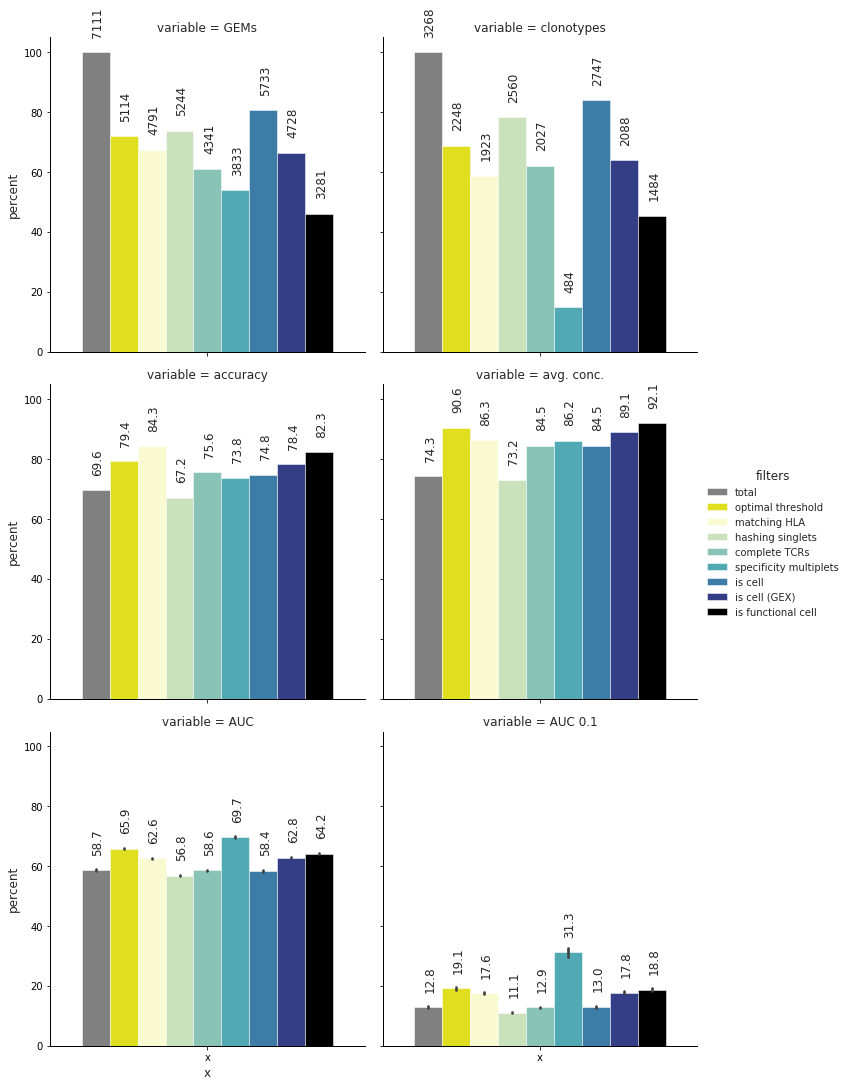

In [142]:
cnt_flat = [[y[i] for y in cnt.to_list()] for i in range(6)]

#plt.figure(figsize=(7,3))#13,5
g = sns.catplot(data=test_df, hue='filters',y='percent',x='x', col='variable', col_wrap=2,
                 palette=palette, ci='sd', kind='bar') #['grey','#ffffcc','#c7e9b4','#7fcdbb','#41b6c4','#2c7fb8','#253494']
#g.fig.set_size_inches(5,7)
for ax, c_lst in zip(g.axes, cnt_flat):
    for p, c in zip(ax.patches, c_lst):
        if type(c) == int:
            ax.annotate("%d" % c, xy=(p.get_x()+p.get_width()/2, p.get_height()), #p.get_width()
            xytext=(2, 15), textcoords='offset points', ha="center", va="bottom", size=12, rotation=90)
        else:
            ax.annotate("%.1f" % round(c,1), xy=(p.get_x()+p.get_width()/2, p.get_height()), #p.get_width()
            xytext=(2, 15), textcoords='offset points', ha="center", va="bottom", size=12, rotation=90) #
    
#ax.legend(title=False, frameon=False, bbox_to_anchor=(1.1,0.5), loc=6)
sns.despine()#trim=True, offset={'left':10}
plt.xlabel('')
plt.ylabel('')
#plt.savefig('../experiments/exp13/run1_archive/plt/eval_filters/sco.indv_thr.png', bbox_inches='tight')
plt.show()

In [59]:
smry.fillna(0, inplace=True)
smry.reset_index(inplace=True)
#smry['data'] = smry.index.get_level_values('data')
pmhc.fillna(0, inplace=True)
pmhc.reset_index(inplace=True)

In [60]:
cnt = plt_df.groupby('filters', sort=False).counts.apply(list) #'filters'
prc = plt_df.groupby('filters', sort=False).percent.apply(list)
cnt_flat = [x for y in cnt.to_list() for x in y] #[item for sublist in t for item in sublist]

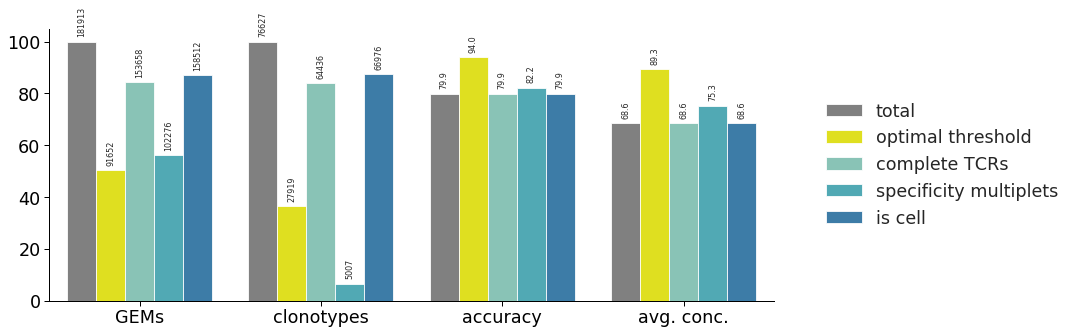

In [61]:
plt.figure(figsize=(13,5))#7
ax = sns.barplot(data=plt_df, hue='filters',y='percent',x='variable',
                 palette=palette) #['grey','#ffffcc','#c7e9b4','#7fcdbb','#41b6c4','#2c7fb8','#253494']
for p, c in zip(ax.patches, cnt_flat):
    if type(c) == int:
        ax.annotate("%d" % c, xy=(p.get_x()+p.get_width()/2, p.get_height()), #p.get_width()
            xytext=(0, 5), textcoords='offset points', ha="center", va="bottom", size=8, rotation=90)
    else:
        ax.annotate("%.1f" % c, xy=(p.get_x()+p.get_width()/2, p.get_height()), #p.get_width()
                xytext=(0, 5), textcoords='offset points', ha="center", va="bottom", size=8, rotation=90) #
    
ax.legend(title=False, frameon=False, bbox_to_anchor=(1.05,0.5), loc=6)
sns.despine()#trim=True, offset={'left':10}
plt.xlabel('')
plt.ylabel('')
#plt.savefig('../experiments/exp13/run1_archive/plt/eval_filters/sco.indv_thr.png', bbox_inches='tight')
plt.savefig('../experiments/exp10x/run1/plt/eval_filters/sco.indv_thr.png', bbox_inches='tight')
plt.show()

The recommended combination is opt thr + matching HLA. Adding "is cell" improves accuracy and avg concordance, but at the expense of the GEMs. Filtering by HTO performs worse than filtering on "is cell". Filtering on specificity multiplets yields the least performance, followed by HTO.

In [49]:
a = set(df[~idx1].gem)
b = set(df[idx8].gem)

In [50]:
gem_additional = b-a

In [51]:
df.loc[df.gem.isin(gem_additional), ['ct','binding_concordance','hto_global_class','tcr_category','single_barcode_mhc','peptide_HLA','ct_pep','umi_count_mhc','delta_umi_mhc']]#.dropna()#.value_counts()

,ct,binding_concordance,hto_global_class,tcr_category,single_barcode_mhc,peptide_HLA,ct_pep,umi_count_mhc,delta_umi_mhc
0,4860.0,1.0,Doublet,multiple chains,pMHC multiplet,RPHERNGFTVL B0702,NaN,4.0,3.200000
1,2833.0,1.0,Singlet,unique chains,pMHC multiplet,RVRAYTYSK A0301,NaN,7.0,2.153846
3,115.0,1.0,Singlet,unique chains,pMHC multiplet,CLGGLLTMV A0201,CLGGLLTMV A0201,19.0,15.200000
4,25.0,1.0,Singlet,unique chains,pMHC multiplet,TPRVTGGGAM B0702,TPRVTGGGAM B0702,33.0,26.400000
5,5444.0,1.0,Singlet,unique chains,pMHC singlet,RVRAYTYSK A0301,NaN,3.0,12.000000
...,...,...,...,...,...,...,...,...,...
7096,5844.0,1.0,Singlet,missing chain,pMHC multiplet,TPRVTGGGAM B0702,NaN,10.0,3.076923
7098,4395.0,1.0,Singlet,missing chain,pMHC singlet,RVRAYTYSK A0301,NaN,9.0,36.000000
7102,629.0,1.0,Singlet,missing chain,pMHC multiplet,RVRAYTYSK A0301,NaN,4.0,3.200000
7105,767.0,1.0,Doublet,missing chain,pMHC singlet,RVRAYTYSK A0301,NaN,4.0,16.000000


In [270]:
df[df.gem.isin(gem_additional)].tcr_category.value_counts()

unique chains      184
missing chain      120
multiple chains     17
Name: tcr_category, dtype: int64

In [271]:
df[~df.gem.isin(gem_additional)].tcr_category.value_counts()

unique chains      3736
missing chain      2650
multiple chains     404
Name: tcr_category, dtype: int64

In [252]:
df[~idx1 & idx8].train_label.value_counts()

False    65
True     34
Name: train_label, dtype: int64

In [253]:
df[idx1 & idx8].train_label.value_counts()

True     1464
False     258
Name: train_label, dtype: int64

In [254]:
df[idx1 & ~idx8].train_label.value_counts()

True     687
False    301
Name: train_label, dtype: int64

In [247]:
df[~idx1 & idx8].umi_count_mhc.value_counts()

1.0    274
2.0     32
3.0      6
5.0      6
4.0      2
6.0      1
Name: umi_count_mhc, dtype: int64

In [248]:
df[~idx1 & idx8].delta_umi_mhc.value_counts()

4.000000    145
0.800000    129
0.888889     32
0.923077      6
0.952381      6
0.941176      2
0.960000      1
Name: delta_umi_mhc, dtype: int64

In [238]:
grp = plt_df[(plt_df.filters != 'total') & (plt_df.variable != 'clonotypes')].groupby(['filters'])#.get_group('optimal threshold')

for f, grp_tmp in grp:
    print(f, ((grp_tmp[grp_tmp.variable == 'GEMs'].percent.values + 2* grp_tmp[grp_tmp.variable == 'accuracy'].percent.values) / 3)[0])

complete TCRs 70.74875544930389
hashing singlets 69.38163408803263
is cell 76.74052407068861
is cell (GEX) 74.42951296114002
is functional cell 70.24659447803872
matching HLA 78.65816340880326
optimal threshold 76.9055828997328
specificity multiplets 67.16746824169128


In [210]:
grp = plt_df[(plt_df.filters != 'total') & (plt_df.variable != 'clonotypes')].groupby(['filters'])#.get_group('optimal threshold')

for f, grp_tmp in grp:
    print(f, ((grp_tmp[grp_tmp.variable == 'GEMs'].percent.values + 2* grp_tmp[grp_tmp.variable == 'accuracy'].percent.values) / 3)[0])

complete TCRs 72.92987390427976
hashing singlets 69.57929030141095
is cell 76.8861857216519
is cell (GEX) 76.54138658416538
is functional cell 72.84184127876999
matching HLA 78.20288754511789
optimal threshold 76.9055828997328
specificity multiplets 68.06103220362819


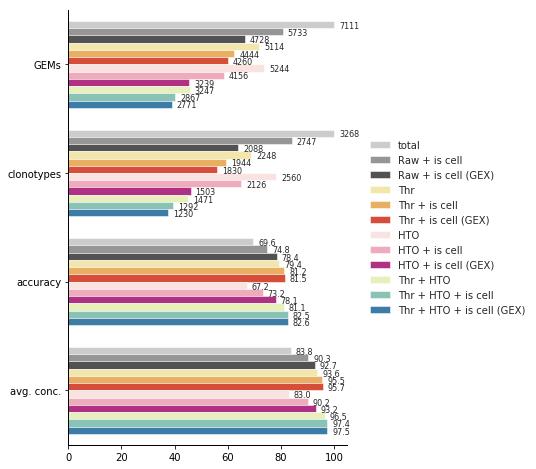

In [57]:
plt.figure(figsize=(5,8))#7
ax = sns.barplot(data=plt_df, hue='filters',x='percent',y='variable',
                 palette=palette) #['grey','#ffffcc','#c7e9b4','#7fcdbb','#41b6c4','#2c7fb8','#253494']
for p, c in zip(ax.patches, cnt_flat):
    if type(c) == int:
        ax.annotate("%d" % c, xy=(p.get_width(), p.get_y()+p.get_height()/2), #p.get_width()
            xytext=(5, -1), textcoords='offset points', ha="left", va="center", size=8)
    else:
        ax.annotate("%.1f" % c, xy=(p.get_width(), p.get_y()+p.get_height()/2), #p.get_width()
                xytext=(5, -1), textcoords='offset points', ha="left", va="center", size=8) #
    
ax.legend(title=False, frameon=False, bbox_to_anchor=(1.05,0.5), loc=6)
sns.despine()#trim=True, offset={'left':10}
plt.xlabel('')
plt.ylabel('')
plt.show()

In [58]:
## UGLY hack to avoid the empty bar
#tmp = pd.DataFrame([0,0,'opt. thr. & hashing',3], index=['freq','frac','data','pos'], columns=['outlier'])
#tmp.columns = pd.MultiIndex.from_tuples([('outlier','multiple chains')])
#smry = pd.concat([smry, tmp.T])

<Figure size 504x360 with 0 Axes>

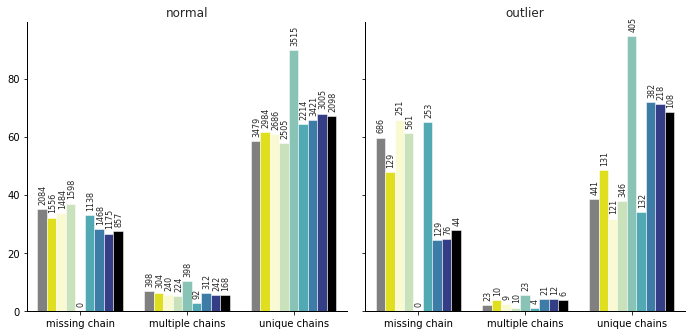

In [93]:
plt.figure(figsize=(7,5))
g = sns.catplot(data=smry.reset_index(), col='binding_category', y='frac', x='tcr_category', hue='data',
                kind='bar', sharey=True, margin_titles=True, palette=palette, legend=False)

for ax, d in zip(g.axes.flatten(), smry.binding_category.unique()): #smry.index.get_level_values(1).unique()
    for p, c in zip(ax.patches, smry[smry.binding_category == d].freq.values): #.sort_values(by=['pos','tcr_category'])
        if any(smry.freq > 1000):
            ax.annotate("%d" % c, xy=(p.get_x()+p.get_width()/2, p.get_height()), #
                        xytext=(1, 5), textcoords='offset points', ha="center", va="bottom", size=8, rotation=90)
        else:
            ax.annotate("%d" % c, xy=(p.get_x()+p.get_width()/2, p.get_height()), #p.get_width()
                xytext=(0, 5), textcoords='offset points', ha="center", va="center", size=8)

g.set_titles(col_template="{col_name}")#, row_template="{row_name}"
g.set_xlabels('')
g.set_ylabels('')
#plt.suptitle('Normalized difference between outliers and "normal" observations', y=1.05)
sns.despine() #trim=True, offset={'left':10}
#plt.savefig('../experiments/exp13/run1_archive/plt/eval_filters/tcr.thr_vs_hto_gex.png')
plt.show()

In [141]:
smry.reset_index(inplace=True)

In [161]:
sub_smry = smry[smry.data.isin(['total','is cell','is cell (GEX)','is viable cell'])]
#sub_smry = smry

In [162]:
tmp = sub_smry.groupby(['data','tcr_category'],sort=False).freq.sum().to_frame().reset_index()
for d, grp in tmp.groupby('data'):
    tmp.loc[tmp.data == d, 'frac'] = grp.freq / grp.freq.sum()

In [163]:
tmp.tcr_category = tmp.tcr_category.str.split().apply(lambda x: '\n'.join(x))

<Figure size 288x144 with 0 Axes>

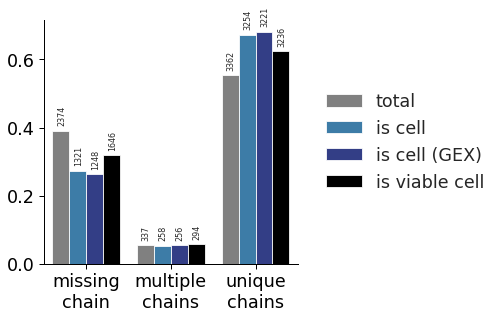

In [165]:
plt.figure(figsize=(4,2))
g = sns.catplot(data=tmp, y='frac', x='tcr_category', hue='data',
                kind='bar', sharey=True, margin_titles=True, palette=[palette[0]]+palette[-3:], legend=False)

#for ax, d in zip(g.axes.flatten(), smry.binding_category.unique()): #smry.index.get_level_values(1).unique()
ax = g.axes[0][0]
for p, c in zip(ax.patches, tmp.freq.values): #.sort_values(by=['pos','tcr_category'])
    if any(smry.freq > 1000):
        ax.annotate("%d" % c, xy=(p.get_x()+p.get_width()/2, p.get_height()), #
                    xytext=(1, 5), textcoords='offset points', ha="center", va="bottom", size=8, rotation=90)
    else:
        ax.annotate("%d" % c, xy=(p.get_x()+p.get_width()/2, p.get_height()), #p.get_width()
            xytext=(0, 5), textcoords='offset points', ha="center", va="center", size=8)

ax.legend(title=False, frameon=False, bbox_to_anchor=(1.05,0.5), loc=6)
g.set_titles(col_template="{col_name}")#, row_template="{row_name}"
g.set_xlabels('')
g.set_ylabels('')
#plt.suptitle('Normalized difference between outliers and "normal" observations', y=1.05)
sns.despine() #trim=True, offset={'left':10}
plt.savefig('../experiments/exp13/run3/plt/eval_filters/tcr.is_cell.png', bbox_inches='tight')
plt.show()

In [129]:
# is cell, missing chain
(2770-1597)/2770 * 100

42.34657039711192

In [131]:
# is cell, multiple chains
(421-333)/421 * 100

20.902612826603324

In [132]:
# is cell, unique chains
(3920-3803)/3920 * 100

2.9846938775510203

In [133]:
# GEX, missing chain
(2770-1251)/2770 * 100

54.837545126353795

In [137]:
# GEX, multipel chains
(421-254)/421 * 100

39.66745843230404

In [135]:
# GEX, unique chains
(3920-3223)/3920 * 100

17.78061224489796

In [136]:
# is functional, missing chain
(2770-901)/2770* 100

67.47292418772564

In [138]:
# is functional, multiple chains
(421-174)/421 * 100

58.66983372921615

In [139]:
# is functional, unique chains
(3920-2206)/3920 * 100

43.72448979591837

<Figure size 360x504 with 0 Axes>

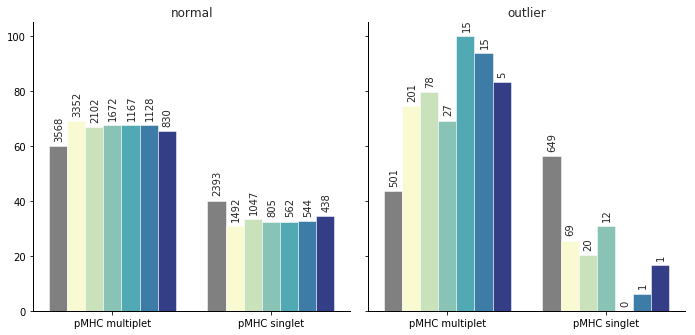

In [57]:
plt.figure(figsize=(5,7))
g = sns.catplot(data=pmhc.reset_index(), col='binding_category', y='frac', x='single_barcode_mhc',
                hue='data', kind='bar', sharey=True, margin_titles=True, palette=palette, legend=False)

for ax, d in zip(g.axes.flatten(), pmhc.binding_category.unique()):
    for p, c in zip(ax.patches, pmhc[pmhc.binding_category == d].freq.values):
        if any(pmhc.sort_index().freq.values > 1000):
            ax.annotate("%d" % c, xy=(p.get_x()+p.get_width()/2, p.get_height()), #p.get_width()
                xytext=(1, 5), textcoords='offset points', ha="center", va="bottom", size=10, rotation=90)
        else:
            ax.annotate("%d" % c, xy=(p.get_x()+p.get_width()/2, p.get_height()), #p.get_width()
                xytext=(0, 5), textcoords='offset points', ha="center", va="center", size=10)
        
g.set_titles(col_template="{col_name}")#, row_template="{row_name}"
g.set_xlabels('')
g.set_ylabels('')
#plt.suptitle('Single barcode pMHC annotations', y=1.05)
#plt.savefig('../experiments/exp13/run1_archive/plt/eval_filters/pep.thr_vs_hto_gex.png')
plt.show()

In [166]:
pmhc

freq       frac  \
data                   binding_category single_barcode_mhc                    
total                  normal           pMHC multiplet      3481  67.174836   
                                        pMHC singlet        1701  32.825164   
                       outlier          pMHC multiplet       457  51.290685   
                                        pMHC singlet         434  48.709315   
optimal threshold      normal           pMHC multiplet      3318  70.356234   
                                        pMHC singlet        1398  29.643766   
                       outlier          pMHC multiplet       210  77.777778   
                                        pMHC singlet          60  22.222222   
matching HLA           normal           pMHC multiplet      2918    67.1422   
                                        pMHC singlet        1428    32.8578   
                       outlier          pMHC multiplet       312  47.416413   
                                        pMHC singlet         346  52.583587   
hashing singlets       normal           pMHC multiplet      2580  65.482234   
                                        pMHC singlet        1360  34.517766   
                       outlier          pMHC multiplet       238  63.466667   
                                        pMHC singlet         137  36.533333   
complete TCRs          normal           pMHC multiplet      2430  70.190641   
                                        pMHC singlet        1032  29.809359   
                       outlier          pMHC multiplet       192  81.012658   
                                        pMHC singlet          45  18.987342   
specificity multiplets normal           pMHC multiplet      2232  65.705034   
                                        pMHC singlet        1165  34.294966   
                       outlier          pMHC multiplet       130  45.454545   
                                        pMHC singlet         156  54.545455   
is cell                normal           pMHC multiplet      3091  68.918618   
                                        pMHC singlet        1394  31.081382   
                       outlier          pMHC multiplet       269  77.298851   
                                        pMHC singlet          79  22.701149   
is cell (GEX)          normal           pMHC multiplet      3054  69.567198   
                                        pMHC singlet        1336  30.432802   
                       outlier          pMHC multiplet       266  79.402985   
                                        pMHC singlet          69  20.597015   
is viable cell         normal           pMHC multiplet      3287  68.450646   
                                        pMHC singlet        1515  31.549354   
                       outlier          pMHC multiplet       280   74.86631   
                                        pMHC singlet          94   25.13369   

                                                            pos  
data                   binding_category single_barcode_mhc       
total                  normal           pMHC multiplet      NaN  
                                        pMHC singlet        NaN  
                       outlier          pMHC multiplet      NaN  
                                        pMHC singlet        NaN  
optimal threshold      normal           pMHC multiplet      NaN  
                                        pMHC singlet        NaN  
                       outlier          pMHC multiplet      NaN  
                                        pMHC singlet        NaN  
matching HLA           normal           pMHC multiplet      NaN  
                                        pMHC singlet        NaN  
                       outlier          pMHC multiplet      NaN  
                                        pMHC singlet        NaN  
hashing singlets       normal           pMHC multiplet      NaN  
                                        pMHC singlet        NaN  
 

<Figure size 288x144 with 0 Axes>

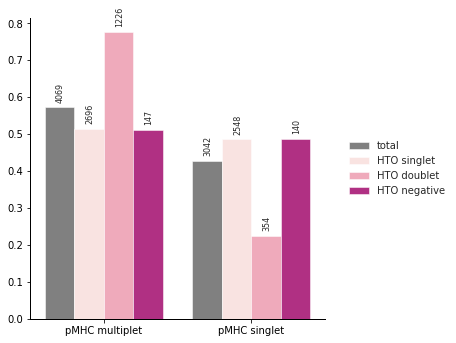

In [303]:
sub_pmhc = pmhc
tmp = sub_pmhc.groupby(['data','single_barcode_mhc'],sort=False).freq.sum().to_frame().reset_index()
for d, grp in tmp.groupby('data'):
    tmp.loc[tmp.data == d, 'frac'] = grp.freq / grp.freq.sum()
    
plt.figure(figsize=(4,2))
g = sns.catplot(data=tmp, y='frac', x='single_barcode_mhc', hue='data',
                kind='bar', sharey=True, margin_titles=True, palette=[palette[0]]+palette[-3:], legend=False)

#for ax, d in zip(g.axes.flatten(), smry.binding_category.unique()): #smry.index.get_level_values(1).unique()
ax = g.axes[0][0]
for p, c in zip(ax.patches, tmp.freq.values): #.sort_values(by=['pos','tcr_category'])
    if any(smry.freq > 1000):
        ax.annotate("%d" % c, xy=(p.get_x()+p.get_width()/2, p.get_height()), #
                    xytext=(1, 5), textcoords='offset points', ha="center", va="bottom", size=8, rotation=90)
    else:
        ax.annotate("%d" % c, xy=(p.get_x()+p.get_width()/2, p.get_height()), #p.get_width()
            xytext=(0, 5), textcoords='offset points', ha="center", va="center", size=8)

ax.legend(title=False, frameon=False, bbox_to_anchor=(1.05,0.5), loc=6)
g.set_titles(col_template="{col_name}")#, row_template="{row_name}"
g.set_xlabels('')
g.set_ylabels('')
sns.despine() #trim=True, offset={'left':10}
#plt.savefig('../experiments/exp13/run1_archive/plt/eval_filters/tcr.is_cell.png', bbox_inches='tight')
plt.show()

In [304]:
pmhc

,data,binding_category,single_barcode_mhc,freq,frac,pos
0,total,normal,pMHC multiplet,3568,59.855729,0
1,total,normal,pMHC singlet,2393,40.144271,0
2,total,outlier,pMHC multiplet,501,43.565217,0
3,total,outlier,pMHC singlet,649,56.434783,0
4,HTO singlet,normal,pMHC multiplet,2349,54.287035,0
5,HTO singlet,normal,pMHC singlet,1978,45.712965,0
6,HTO singlet,outlier,pMHC multiplet,347,37.840785,0
7,HTO singlet,outlier,pMHC singlet,570,62.159215,0
8,HTO doublet,normal,pMHC multiplet,1165,77.254642,0
9,HTO doublet,normal,pMHC singlet,343,22.745358,0


In [69]:
any(pmhc.sort_index().freq.values > 1000)

True

In [202]:
tmp.loc[tmp.binding_concordance <= 0.5, ['ct','peptide_HLA','peptide_HLA_lst','binding_concordance']]

,ct,peptide_HLA,peptide_HLA_lst,binding_concordance
808,35.0,RVRAYTYSK A0301,"[TPRVTGGGAM B0702, YVLDHLIVV A0201, RVRAYTYSK ...",0.090909
1600,17.0,RVRAYTYSK A0301,"[RPPIFIRRL B0702, RVRAYTYSK A0301]",0.022222
2806,10.0,RVRAYTYSK A0301,"[RPPIFIRRL B0702, RVRAYTYSK A0301]",0.076923
3428,10.0,RVRAYTYSK A0301,"[RPPIFIRRL B0702, RVRAYTYSK A0301]",0.076923
4255,16.0,RPPIFIRRL B0702,"[RVRAYTYSK A0301, TPSVSSSISSL B0702, TPRVTGGGA...",0.333333


In [207]:
tmp.loc[tmp.ct==35, ['peptide_HLA','peptide_HLA_lst', 'umi_count_lst_mhc']]

,peptide_HLA,peptide_HLA_lst,umi_count_lst_mhc
144,YVLDHLIVV A0201,[YVLDHLIVV A0201],[13.0]
399,YVLDHLIVV A0201,"[RVRAYTYSK A0301, YVLDHLIVV A0201]","[2.0, 12.0]"
460,YVLDHLIVV A0201,"[RVRAYTYSK A0301, RPHERNGFTV B0702, YVLDHLIVV ...","[1.0, 1.0, 2.0]"
808,RVRAYTYSK A0301,"[TPRVTGGGAM B0702, YVLDHLIVV A0201, RVRAYTYSK ...","[1.0, 2.0, 4.0]"
934,YVLDHLIVV A0201,"[RVRAYTYSK A0301, YVLDHLIVV A0201]","[1.0, 6.0]"
1143,YVLDHLIVV A0201,"[FLYALALLL A0201, RVRAYTYSK A0301, YVLDHLIVV A...","[1.0, 1.0, 5.0]"
2317,YVLDHLIVV A0201,"[FLYALALLL A0201, RVRAYTYSK A0301, YVLDHLIVV A...","[1.0, 1.0, 5.0]"
2418,YVLDHLIVV A0201,"[VLEETSVML A0201, RVRAYTYSK A0301, YVLDHLIVV A...","[1.0, 1.0, 11.0]"
3556,YVLDHLIVV A0201,"[RPHERNGFTVL B0702, RVRAYTYSK A0301, YVLDHLIVV...","[1.0, 4.0, 12.0]"
4324,YVLDHLIVV A0201,"[CLGGLLTMV A0201, NLVPMVATV A0201, RVRAYTYSK A...","[1.0, 1.0, 5.0, 27.0]"


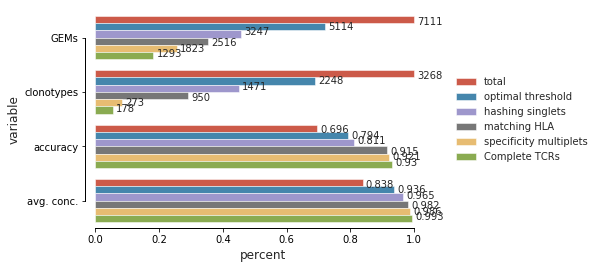

In [138]:
ax = sns.barplot(data=plt_df, hue='filters',x='percent',y='variable')
for i, (_,c) in enumerate(cnt.items()):
    for j,d,v in zip(np.arange(len(plt_df.filters.unique())),[-0.3,-0.2,-0.1,0.1, 0.2,0.3], c):
        y = i+d
        x = prc[i][j] + 0.01
        ax.annotate(str(v), xy=(x, y), ha='left', va='center')

ax.legend(title=False, frameon=False, bbox_to_anchor=(1.05,0.5), loc=6)
sns.despine(trim=True, offset={'left':10})
plt.show()

In [209]:
tmp.groupby(['binding_category','tcr_category']).size().to_frame().rename(columns={0:'freq'})

freq
binding_category tcr_category         
normal           multiple chains    34
                 unique chains    1254
outlier          unique chains       5

In [126]:
plt_df.groupby('filters', sort=False).percent.apply(list)

filters
total                                                        [1, 1]
optimal threshold          [0.7117142455350864, 0.6832925336597307]
matching hashing          [0.5390240472507383, 0.43084455324357407]
specificity multiplets    [0.3687245113204894, 0.07833537331701346]
Name: percent, dtype: object

In [51]:
dfs = list()
for idx, label in zip([idx1, (idx1 & idx2), (idx1 & idx2 & idx3), (idx1 & idx2 & idx3 & idx4)],
                      ['optimal threshold','matching hashing','specificity multiplets', 'Complete TCRs']):
    for cat, l in zip([df.num_clonotype == 0,
                       df.num_clonotype == df.ct,
                       (df.num_clonotype != df.ct) & (df.num_clonotype != 0)], ['novel','reference','alternative']):
        gpc = pd.DataFrame(columns=['gem_counts','filters','category'])
        gpc['gem_counts'] = df[idx & cat].groupby('ct').gem.count().values
        gpc['filters'] = label
        gpc['category'] = l
        dfs.append(gpc)
dfs = pd.concat(dfs)

In [52]:
dfs

,gem_counts,filters,category
0,8,optimal threshold,novel
1,3,optimal threshold,novel
2,5,optimal threshold,novel
3,5,optimal threshold,novel
4,1,optimal threshold,novel
...,...,...,...
74,1,Complete TCRs,reference
0,1,Complete TCRs,alternative
1,1,Complete TCRs,alternative
2,2,Complete TCRs,alternative


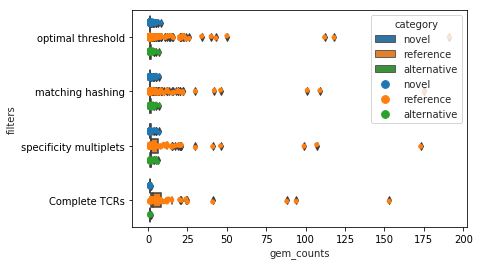

In [55]:
ax = sns.boxplot(data=dfs, x='gem_counts', y='filters', hue='category')
ax = sns.stripplot(data=dfs, x='gem_counts', y='filters', hue='category', dodge=True)
plt.show()

In [38]:
gpc = pd.DataFrame(columns=['gem_counts','filters','categories'])

In [39]:
gpc['gem_counts'] = df.groupby('ct').gem.count()#.values
gpc['filters'] = 'total'

In [40]:
gpc

,gem_counts,filters
ct,,
1.0,204,total
2.0,30,total
3.0,120,total
4.0,126,total
5.0,7,total
...,...,...
7702.0,2,total
7715.0,1,total
7734.0,1,total


In [50]:
df.num_clonotype.value_counts()

0.0       217
1.0       195
4.0       121
3.0       114
7.0        52
         ... 
1435.0      1
343.0       1
3197.0      1
5399.0      1
4913.0      1
Name: num_clonotype, Length: 885, dtype: int64

In [59]:
sum(df.num_clonotype != 0)

1966

In [60]:
sum(df.num_clonotype == 0)

217

In [74]:
sum((df.num_clonotype != 0) & (df.num_clonotype != df.ct) & (~df.ct.isin(df.num_clonotype)) & (df.tcr_category =='missing chain'))

56

In [86]:
df[df.num_clonotype == 2514.0]

,gem,clonotype,num_clonotype,ct,genes_TRA,genes_TRB,genes_lst_TRA,genes_lst_TRB,length_TRA,cdr1_TRA,...,ct_sample,ct_pep,ct_hla,sample_hla,pep_match,hla_match,ct_match,valid_ct,train_label,test_label
1536,TGCTGCTGTAGCTTGT-1,clonotype2514,2514.0,2513.0,TRAV24;TRAJ34;TRAC,NaN,['TRAV24;TRAJ34;TRAC'],NaN,474.0,SSNFYA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True


In [87]:
df[df.ct == 2513.0]

,gem,clonotype,num_clonotype,ct,genes_TRA,genes_TRB,genes_lst_TRA,genes_lst_TRB,length_TRA,cdr1_TRA,...,ct_sample,ct_pep,ct_hla,sample_hla,pep_match,hla_match,ct_match,valid_ct,train_label,test_label
287,ATCACGAGTCTCCACT-1,NaN,0.0,2513.0,TRAV24;TRAJ34;TRAC,NaN,['TRAV24;TRAJ34;TRAC'],NaN,478.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True
620,CGATGGCGTGGTACAG-1,NaN,0.0,2513.0,TRAV24;TRAJ34;TRAC,NaN,['TRAV24;TRAJ34;TRAC'],NaN,477.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True
1536,TGCTGCTGTAGCTTGT-1,clonotype2514,2514.0,2513.0,TRAV24;TRAJ34;TRAC,NaN,['TRAV24;TRAJ34;TRAC'],NaN,474.0,SSNFYA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True


In [75]:
df[(df.num_clonotype != 0) & (df.num_clonotype != df.ct) & (~df.ct.isin(df.num_clonotype))]

,gem,clonotype,num_clonotype,ct,genes_TRA,genes_TRB,genes_lst_TRA,genes_lst_TRB,length_TRA,cdr1_TRA,...,ct_sample,ct_pep,ct_hla,sample_hla,pep_match,hla_match,ct_match,valid_ct,train_label,test_label
928,GACGTTATCGCTTAGA-1,clonotype3635,3635.0,3632.0,TRAV38-2/DV8;TRAJ54;TRAC,NaN,['TRAV38-2/DV8;TRAJ54;TRAC'],NaN,483.0,TSESDYY,...,4.0,RPPIFIRRL B0702,NaN,"['A0301', 'B0702']",True,True,True,True,True,True
1186,GTAGGCCCAACGATGG-1,clonotype1368,1368.0,1362.0,TRAV13-2;TRAJ39;TRAC,TRBV30;;TRBJ2-3;TRBC2,['TRAV13-2;TRAJ39;TRAC'],['TRBV30;;TRBJ2-3;TRBC2'],486.0,NSASDY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True
1536,TGCTGCTGTAGCTTGT-1,clonotype2514,2514.0,2513.0,TRAV24;TRAJ34;TRAC,NaN,['TRAV24;TRAJ34;TRAC'],NaN,474.0,SSNFYA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True
1588,TTAGGACTCTTGTACT-1,clonotype3638,3638.0,3632.0,TRAV38-2/DV8;TRAJ54;TRAC,NaN,['TRAV38-2/DV8;TRAJ54;TRAC'],NaN,487.0,TSESDYY,...,4.0,RPPIFIRRL B0702,NaN,"['A0301', 'B0702']",True,True,True,True,True,True
1723,ACGCAGCCACATTAGC-1,clonotype1703,1703.0,1701.0,NaN,TRBV24-1;;TRBJ1-5;TRBC1,NaN,['TRBV24-1;;TRBJ1-5;TRBC1'],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False
1753,AGCGGTCTCTTAGCCC-1,clonotype1199,1199.0,1198.0,NaN,TRBV2;;TRBJ1-4;TRBC1,NaN,['TRBV2;;TRBJ1-4;TRBC1'],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True
1754,AGCGTATAGATATACG-1,clonotype4756,4756.0,4755.0,NaN,TRBV2;;TRBJ2-3;TRBC2,NaN,['TRBV2;;TRBJ2-3;TRBC2'],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False
1763,AGGTCATTCGATAGAA-1,clonotype3815,3815.0,3814.0,NaN,TRBV5-6;;TRBJ1-1;TRBC1,NaN,['TRBV5-6;;TRBJ1-1;TRBC1'],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True
1764,AGGTCCGTCGCCAAAT-1,clonotype2602,2602.0,2601.0,NaN,TRBV11-2;;TRBJ1-1;TRBC1,NaN,['TRBV11-2;;TRBJ1-1;TRBC1'],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False
1769,AGTGAGGTCACCACCT-1,clonotype5825,5825.0,5824.0,NaN,TRBV7-9;;TRBJ2-1;TRBC2,NaN,['TRBV7-9;;TRBJ2-1;TRBC2'],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True


In [45]:
sum(df.num_clonotype == df.ct)

1855

In [67]:
sum((df.ct.isin(df.num_clonotype)) & (df.num_clonotype == 0))

80

In [56]:
df[df.num_clonotype == df.ct].groupby('ct').gem.count()

ct
1.0       195
2.0        27
3.0       114
4.0       121
5.0         7
         ... 
6799.0      1
6805.0      1
6819.0      1
6837.0      1
6842.0      1
Name: gem, Length: 775, dtype: int64

In [57]:
df[df.num_clonotype == 0].groupby('ct').gem.count()

ct
1.0       9
2.0       3
3.0       6
4.0       5
6.0       1
         ..
7702.0    2
7715.0    1
7734.0    1
7739.0    1
7753.0    1
Name: gem, Length: 170, dtype: int64

In [58]:
df[(df.num_clonotype != df.ct) & (df.num_clonotype != 0)].groupby('ct').gem.count()

ct
75.0      3
115.0     1
139.0     2
257.0     1
259.0     1
         ..
6271.0    2
6277.0    4
6312.0    7
6766.0    1
6769.0    1
Name: gem, Length: 68, dtype: int64

In [88]:
df.columns

Index(['gem', 'clonotype', 'num_clonotype', 'ct', 'genes_TRA', 'genes_TRB',
       'genes_lst_TRA', 'genes_lst_TRB', 'length_TRA', 'cdr1_TRA', 'cdr2_TRA',
       'cdr3_TRA', 'umi_count_TRA', 'umi_count_lst_TRA', 'delta_umi_TRA',
       'cdr3_lst_TRA', 'chain_count_TRA', 'single_TRA', 'length_TRB',
       'cdr1_TRB', 'cdr2_TRB', 'cdr3_TRB', 'umi_count_TRB',
       'umi_count_lst_TRB', 'delta_umi_TRB', 'cdr3_lst_TRB', 'chain_count_TRB',
       'single_TRB', 'single_chain_only', 'umi_count_tcr', 'cdr3_comb',
       'v_gene_TRA', 'j_gene_TRA', 'v_gene_TRB', 'j_gene_TRB', 'tcr_category',
       'no_filtration', 'exclude_single-chain_TCRs',
       'exclude_ambiguous_and_single-chain_TCRs', 'exclude_ambiguous_TCRs',
       'label', 'umi_count_mhc', 'umi_count_lst_mhc', 'delta_umi_mhc',
       'single_barcode_mhc', 'multiplets_mhc', 'umi_count_cd8',
       'umi_count_lst_cd8', 'delta_umi_cd8', 'single_barcode_cd8',
       'multiplets_cd8', 'detected_response', 'peptide_assayed', 'sample_id',
 

In [261]:
df.num_clonotype = 'c' + df.num_clonotype.astype(int).astype(str)

In [288]:
df['chain_a'] = df.v_gene_TRA.fillna('') + ";" + df.j_gene_TRA.fillna('') + ";" + df.cdr3_TRA.fillna('')
df['chain_b'] = df.v_gene_TRB.fillna('') + ";" + df.j_gene_TRB.fillna('') + ";" + df.cdr3_TRB.fillna('')
df['chains'] = df.chain_a + '|' + df.chain_b

In [289]:
c10 = df[df.num_clonotype!='c0'].groupby(['num_clonotype','chain_a','chain_b','chains']).gem.size().reset_index().drop_duplicates(subset='num_clonotype', keep='last').rename(columns={'num_clonotype':'clonotype'})
c10#.head(60)

,clonotype,chain_a,chain_b,chains,gem
1,c1,TRAV30;TRAJ38;CGTEGAGNNRKLIW,TRBV3-1;TRBJ1-5;CASSQVFGTPTPQHF,TRAV30;TRAJ38;CGTEGAGNNRKLIW|TRBV3-1;TRBJ1-5;C...,172
2,c10,TRAV29/DV5;TRAJ21;CAASGDFNKFYF,TRBV27;TRBJ2-3;CASSPSPRGFTDTQYF,TRAV29/DV5;TRAJ21;CAASGDFNKFYF|TRBV27;TRBJ2-3;...,1
3,c1001,TRAV12-2;TRAJ30;CAAASPRDDKIIF,TRBV30;TRBJ1-4;CAWSEGTNEKLFF,TRAV12-2;TRAJ30;CAAASPRDDKIIF|TRBV30;TRBJ1-4;C...,1
4,c1008,TRAV13-1;TRAJ20;CAALEFPNDYKLSF,TRBV20-1;TRBJ2-1;CSANRGDPREQFF,TRAV13-1;TRAJ20;CAALEFPNDYKLSF|TRBV20-1;TRBJ2-...,1
5,c1017,TRAV12-3;TRAJ43;CAVGYNNNDMRF,TRBV15;TRBJ2-3;CATRTGGAQYF,TRAV12-3;TRAJ43;CAVGYNNNDMRF|TRBV15;TRBJ2-3;CA...,1
...,...,...,...,...,...
905,c969,TRAV5;TRAJ31;CAHDNNARLMF,TRBV20-1;TRBJ1-2;CSARDGVGNGYTF,TRAV5;TRAJ31;CAHDNNARLMF|TRBV20-1;TRBJ1-2;CSAR...,1
906,c974,TRAV29/DV5;TRAJ7;CAASGSRLAF,TRBV2;TRBJ2-1;CASSSGQGAPYNEQFF,TRAV29/DV5;TRAJ7;CAASGSRLAF|TRBV2;TRBJ2-1;CASS...,1
907,c985,TRAV9-2;TRAJ6;CAPRRGGSYIPTF,TRBV29-1;TRBJ2-2;CSVGTDETGELFF,TRAV9-2;TRAJ6;CAPRRGGSYIPTF|TRBV29-1;TRBJ2-2;C...,1
908,c986,TRAV12-3;TRAJ21;CAMNNFNKFYF,TRBV20-1;TRBJ2-1;CSARDSGGQEQFF,TRAV12-3;TRAJ21;CAMNNFNKFYF|TRBV20-1;TRBJ2-1;C...,1


In [290]:
c00 = df[df.num_clonotype=='c0'].groupby(['num_clonotype','chain_a','chain_b','chains']).gem.size().reset_index().rename(columns={'num_clonotype':'clonotype'})
c00

,clonotype,chain_a,chain_b,chains,gem
0,c0,;;,TRBV10-2;TRBJ1-1;CASSADGMNTEAFF,;;|TRBV10-2;TRBJ1-1;CASSADGMNTEAFF,1
1,c0,;;,TRBV10-3;TRBJ2-5;CAISDGTGERGTQYF,;;|TRBV10-3;TRBJ2-5;CAISDGTGERGTQYF,1
2,c0,;;,TRBV10-3;TRBJ2-5;CAISEGRETQYF,;;|TRBV10-3;TRBJ2-5;CAISEGRETQYF,1
3,c0,;;,TRBV10-3;TRBJ2-5;CAISESSGGRQETQYF,;;|TRBV10-3;TRBJ2-5;CAISESSGGRQETQYF,1
4,c0,;;,TRBV11-1;TRBJ2-7;CASSWGASHFWGQYF,;;|TRBV11-1;TRBJ2-7;CASSWGASHFWGQYF,1
...,...,...,...,...,...
167,c0,TRAV8-1;TRAJ49;CAGAGTGNQFYF,;;,TRAV8-1;TRAJ49;CAGAGTGNQFYF|;;,1
168,c0,TRAV8-1;TRAJ6;CAGGSYIPTF,TRBV7-3;TRBJ2-1;CASSLIVSGGANEQFF,TRAV8-1;TRAJ6;CAGGSYIPTF|TRBV7-3;TRBJ2-1;CASSL...,1
169,c0,TRAV8-2;TRAJ8;CVVSGFQKLVF,;;,TRAV8-2;TRAJ8;CVVSGFQKLVF|;;,1
170,c0,TRAV9-2;TRAJ43;CALNKGRNDMRF,;;,TRAV9-2;TRAJ43;CALNKGRNDMRF|;;,1


In [274]:
#c10 = pd.concat([c10,c00], ignore_index=True)

In [ ]:
def get_alpha_pairs(row):
    return ((c10.chain_a.isin([row.chain_a]) &
             (c10.clonotype != row.clonotype)).astype(int).to_list() +
            [int(any(c00.chain_a.isin([row.chain_a])))])

In [304]:
def get_beta_pairs(row):
    return ((c10.chain_b.isin([row.chain_b]) &
             (c10.clonotype != row.clonotype)).astype(int).to_list() +
            [int(any(c00.chain_b.isin([row.chain_b])))])

In [291]:
def get_pairs(row):
    return ((c10.chains.isin([row.chains]) &
             (c10.clonotype != row.clonotype)).astype(int).to_list() +
            [int(any(c00.chains.isin([row.chains])))])

In [305]:
c10['pairs'] = c10.apply(lambda row: get_beta_pairs(row), axis=1)

In [306]:
#c10['pairs'] = c10.apply(lambda row: c10.loc[c10.chain_a.isin([row.chain_a]) &
#                                             (c10.clonotype != row.clonotype), 'clonotype'].to_list(), axis=1)

In [307]:
c10['clones'] = c10.apply(lambda row: c10.clonotype.to_list() + ['c0'], axis=1)

In [308]:
tmp = pd.DataFrame(columns=['clonotype','pairs','clones'])

In [309]:
tmp['clonotype'] = ['c0']

In [311]:
# Count matches of clonotype 0 with the true clonotypes + itself
tmp['pairs'] =  [c10.chain_b.isin(c00.chain_b).astype(int).to_list() + [0]]

In [312]:
# List the true clonotypes
tmp['clones'] = [c10.clonotype.to_list() + ['c0']]

In [313]:
tmp

,clonotype,pairs,clones
0,c0,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[c1, c10, c1001, c1008, c1017, c102, c1020, c1..."


In [314]:
c = pd.concat([c10,tmp], ignore_index=True)

In [315]:
out = c.explode(['pairs','clones']).pivot(index='clonotype',columns='clones', values='pairs').replace(0, np.nan).reset_index().rename(columns={'clonotype':'from'})

In [316]:
out.to_csv('arc_data.b.csv', index=False)

In [303]:
out

clones,from,c0,c1,c10,c1001,c1008,c1017,c102,c1020,c103,...,c95,c954,c956,c960,c963,c969,c974,c985,c986,c989
0,c0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,c1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,c10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,c1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,c1008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,c969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
881,c974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
882,c985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
883,c986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
pd.pivot_table(c10.explode(['pairs','clones']), index=['clonotype','chain_a','chain_b'], columns='clones', values='pairs', aggfunc=np.sum)

clones                                                                       None  \
clonotype    chain_a                      chain_b                                   
None         ;;                           TRBV10-2;TRBJ1-1;CASSADGMNTEAFF       0   
                                          TRBV10-3;TRBJ2-5;CAISDGTGERGTQYF      0   
                                          TRBV10-3;TRBJ2-5;CAISEGRETQYF         0   
                                          TRBV10-3;TRBJ2-5;CAISESSGGRQETQYF     0   
                                          TRBV11-1;TRBJ2-7;CASSWGASHFWGQYF      0   
...                                                                           ...   
clonotype969 TRAV5;TRAJ31;CAHDNNARLMF     TRBV20-1;TRBJ1-2;CSARDGVGNGYTF        0   
clonotype974 TRAV29/DV5;TRAJ7;CAASGSRLAF  TRBV2;TRBJ2-1;CASSSGQGAPYNEQFF        0   
clonotype985 TRAV9-2;TRAJ6;CAPRRGGSYIPTF  TRBV29-1;TRBJ2-2;CSVGTDETGELFF        0   
clonotype986 TRAV12-3;TRAJ21;CAMNNFNKFYF  TRBV20-1;TRBJ2-1;CSARDSGGQEQFF        0   
clonotype989 TRAV12-2;TRAJ50;CAVKTSYDKVIF TRBV7-9;TRBJ2-1;CAGGGHEQFF            0   

clones                                                                       clonotype1  \
clonotype    chain_a                      chain_b                                         
None         ;;                           TRBV10-2;TRBJ1-1;CASSADGMNTEAFF             0   
                                          TRBV10-3;TRBJ2-5;CAISDGTGERGTQYF            0   
                                          TRBV10-3;TRBJ2-5;CAISEGRETQYF               0   
                                          TRBV10-3;TRBJ2-5;CAISESSGGRQETQYF           0   
                                          TRBV11-1;TRBJ2-7;CASSWGASHFWGQYF            0   
...                                                                                 ...   
clonotype969 TRAV5;TRAJ31;CAHDNNARLMF     TRBV20-1;TRBJ1-2;CSARDGVGNGYTF              0   
clonotype974 TRAV29/DV5;TRAJ7;CAASGSRLAF  TRBV2;TRBJ2-1;CASSSGQGAPYNEQFF              0   
clonotype985 TRAV9-2;TRAJ6;CAPRRGGSYIPTF  TRBV29-1;TRBJ2-2;CSVGTDETGELFF              0   
clonotype986 TRAV12-3;TRAJ21;CAMNNFNKFYF  TRBV20-1;TRBJ2-1;CSARDSGGQEQFF              0   
clonotype989 TRAV12-2;TRAJ50;CAVKTSYDKVIF TRBV7-9;TRBJ2-1;CAGGGHEQFF                  0   

clones                                                                       clonotype10  \
clonotype    chain_a                      chain_b                                          
None         ;;                           TRBV10-2;TRBJ1-1;CASSADGMNTEAFF              0   
                                          TRBV10-3;TRBJ2-5;CAISDGTGERGTQYF             0   
                                          TRBV10-3;TRBJ2-5;CAISEGRETQYF                0   
                                          TRBV10-3;TRBJ2-5;CAISESSGGRQETQYF            0   
                                          TRBV11-1;TRBJ2-7;CASSWGASHFWGQYF             0   
...                                                                                  ...   
clonotype969 TRAV5;TRAJ31;CAHDNNARLMF     TRBV20-1;TRBJ1-2;CSARDGVGNGYTF               0   
clonotype974 TRAV29/DV5;TRAJ7;CAASGSRLAF  TRBV2;TRBJ2-1;CASSSGQGAPYNEQFF               0   
clonotype985 TRAV9-2;TRAJ6;CAPRRGGSYIPTF  TRBV29-1;TRBJ2-2;CSVGTDETGELFF               0   
clonotype986 TRAV12-3;TRAJ21;CAMNNFNKFYF  TRBV20-1;TRBJ2-1;CSARDSGGQEQFF               0   
clonotype989 TRAV12-2;TRAJ50;CAVKTSYDKVIF TRBV7-9;TRBJ2-1;CAGGGHEQFF                   0   

clones                                                                       clonotype1001  \
clonotype    chain_a                      chain_b                                            
None         ;;                           TRBV10-2;TRBJ1-1;CASSADGMNTEAFF                0   
                                          TRBV10-3;TRBJ2-5;CAISDGTGERGTQYF               0   
                                          TRBV10-3;TRBJ2-5;CAISEGRETQYF                  0   
                                          T

In [148]:
c10.explode(['pairs','clones']).pivot(index='clonotype',columns='clones', values='pairs')

ValueError: Index contains duplicate entries, cannot reshape

In [91]:
df.genes_TRB.head(60)

0             TRBV9;;TRBJ1-2;TRBC1
1           TRBV3-1;;TRBJ2-5;TRBC2
2           TRBV6-1;;TRBJ1-2;TRBC1
3           TRBV3-1;;TRBJ1-5;TRBC1
4            TRBV14;;TRBJ2-3;TRBC2
5          TRBV20-1;;TRBJ2-6;TRBC2
6           TRBV5-1;;TRBJ2-5;TRBC2
7            TRBV28;;TRBJ2-7;TRBC2
8            TRBV28;;TRBJ2-7;TRBC2
9           TRBV7-6;;TRBJ2-5;TRBC2
10          TRBV7-2;;TRBJ2-1;TRBC2
11           TRBV30;;TRBJ2-7;TRBC2
12         TRBV20-1;;TRBJ1-1;TRBC1
13          TRBV7-9;;TRBJ1-1;TRBC1
14          TRBV6-6;;TRBJ2-5;TRBC2
15    TRBV12-4;TRBD2;TRBJ2-1;TRBC2
16         TRBV20-1;;TRBJ2-3;TRBC2
17         TRBV24-1;;TRBJ1-4;TRBC1
18          TRBV4-3;;TRBJ1-2;TRBC1
19          TRBV7-9;;TRBJ1-1;TRBC1
20           TRBV27;;TRBJ2-7;TRBC2
21          TRBV7-9;;TRBJ2-2;TRBC2
22         TRBV20-1;;TRBJ2-7;TRBC2
23          TRBV7-9;;TRBJ1-1;TRBC1
24          TRBV3-1;;TRBJ1-5;TRBC1
25           TRBV27;;TRBJ2-7;TRBC2
26           TRBV27;;TRBJ2-2;TRBC2
27     TRBV6-1;TRBD1;TRBJ2-4;TRBC2
28          TRBV5-1;